# Advance Lane Lines

In [1]:
import os
import numpy as np
import glob
import cv2
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Camera calibration and distorsion correction

The following code is base in the Udacity repository:  [CarND-Camera-Calibration](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb)

Create the image and object points to calibrate the camera. 
The object points are the same for all the images as all the calibration images are chess boards of the same dimension (6x9). 
The images points are arrays with the coordinates of the corners.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
                                          
print("Object point (1st row):")
print(objp[0:9,:])                                          

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

print("\nImages uses for calibrate the camera: ")
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        print(idx, " ", end="")
        objpoints.append(objp)
        imgpoints.append(corners)

print("\n\nImages points (1st row):")
print(imgpoints[-1][0:9,0])

Object point (1st row):
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]]

Images uses for calibrate the camera: 
1  2  3  4  5  6  7  8  9  10  11  12  13  16  17  18  19  

Images points (1st row):
[[ 622.59265137  147.06881714]
 [ 661.09936523  162.3087616 ]
 [ 697.16424561  177.31687927]
 [ 731.43341064  191.54307556]
 [ 763.58007812  205.2311554 ]
 [ 793.96057129  218.34494019]
 [ 822.22521973  230.58702087]
 [ 849.57891846  242.73017883]
 [ 874.94610596  253.94567871]]


Display an example of how the images points are created . The coordinates of the corners in the image point are saved and they will be compared with object points to calibrate the camera. The calibration camera uses multiple images, in our case we have 19 calibration images.

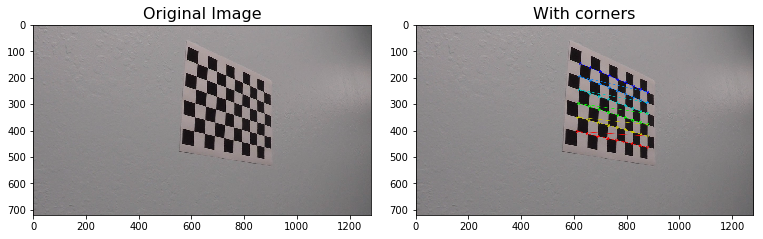

In [3]:
#Display orignal and corner images of the read image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=16)
cv2.drawChessboardCorners(img, (9, 6), corners, ret)
ax2.imshow(img)
ax2.set_title('With corners', fontsize=16)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Use the object points and the image points to calibrate the camera

In [4]:
#Take the last calibration image as reference image
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

Create the pipeline function for undistort images using the calibration camera parameters

In [5]:
def undistortImg(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Test the undistorsion function

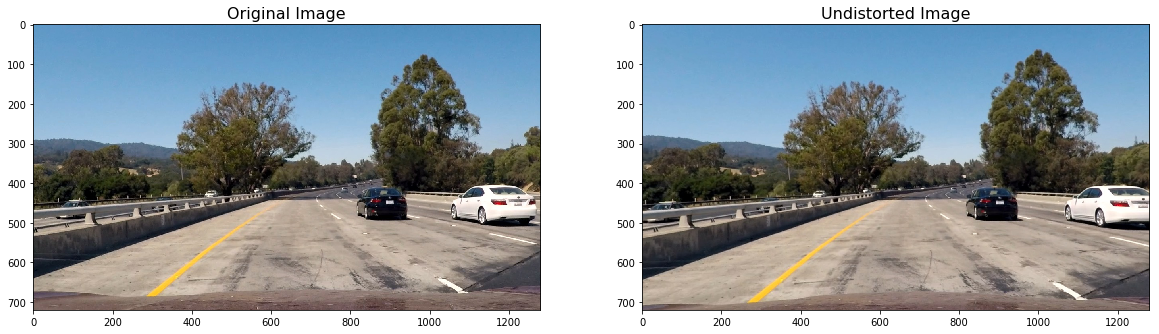

In [6]:
#Take test1.jpg image as reference image
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Pipeline: Get the undistorted images
dst = undistortImg(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=16)
img_size = (img.shape[1], img.shape[0])

## 2. Perpective transformation

In order to change the perpesctive of a image, the source and destination area should be defined:

In [7]:
#Take test1.jpg image as reference image
img = cv2.imread('test_images/test1.jpg')

#Get the shape from the image
imshape = np.array(img).shape
    
#Define the points of the source area
srcPointDownLeft  = [ int(imshape[1]*0.15),  int(imshape[0]*0.95) ]
srcPointUpLeft    = [ int(imshape[1]*0.40),  int(imshape[0]*0.65) ]

srcPointDownRight = [ int(imshape[1]*0.90),  int(imshape[0])*0.95]
srcPointUpRight   = [ int(imshape[1]*0.60),  int(imshape[0]*0.65) ]
    
#Define the source area 
src = np.float32([srcPointDownLeft, srcPointUpLeft, srcPointUpRight, srcPointDownRight])
       
#Define the points of the destination area
destPointDownLeft  = [ int(imshape[1]*0.15),  int(imshape[0]*0.95)]
destPointUpLeft    = [ int(imshape[1]*0.05),  int(imshape[0]*0.0)]

destPointDownRight = [ int(imshape[1]*0.85),  int(imshape[0])*0.95]
destPointUpRight   = [ int(imshape[1]*1.00),  int(imshape[0]*0.0)]

#Define the dest area 
dst = np.float32([destPointDownLeft, destPointUpLeft, destPointUpRight, destPointDownRight])

Create the pipeline function for get a bird eye perspective using the source and destination area defined before

In [8]:
def birdEye(img, src, dst): 
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src , dst)
    
    # Given src and dst points, calculate the inverse perspective transform matrix
    Mi = cv2.getPerspectiveTransform(dst, src )
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Mi

Test the birdEye function using the test images. The red polygon is the source area while the green one is the destination area.

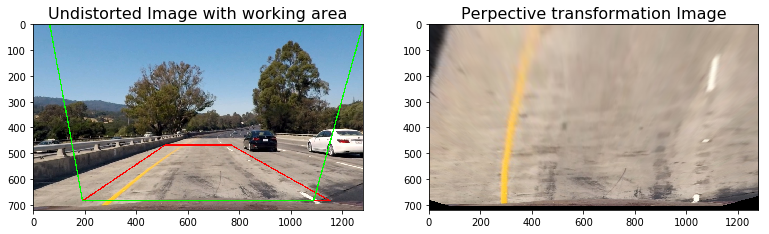

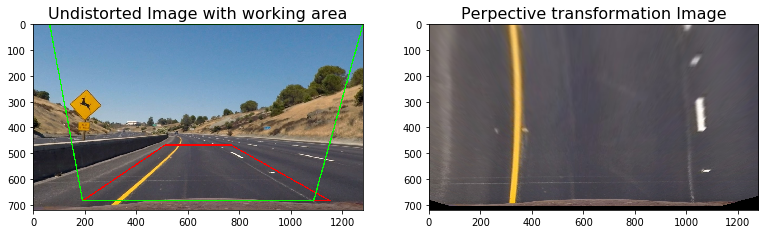

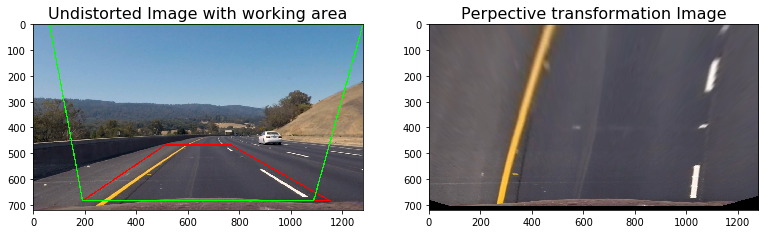

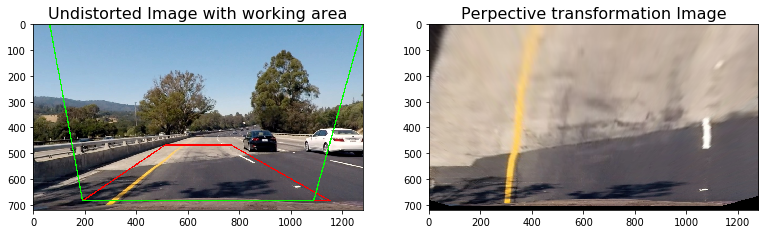

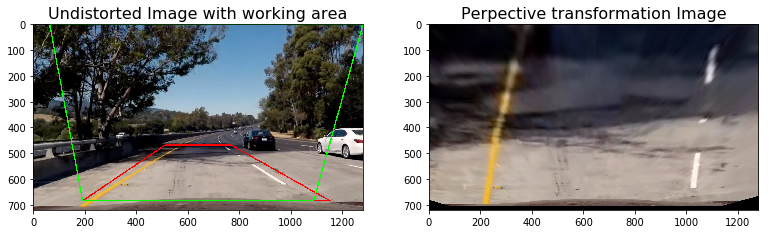

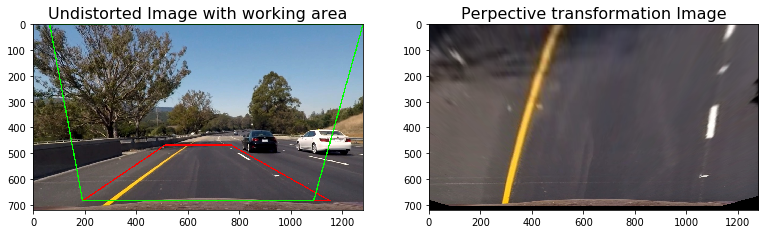

In [9]:
images = glob.glob('test_images/test*.jpg')

imgs = []
imgsWarped = []

for idx, fname in enumerate(images):
    
    #Read image and transform to RGB
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
        
    #Pipeline: Get the perspective transformation of the undistorted images
    img = undistortImg(img, mtx, dist)
    imgWarped, M, Mi = birdEye(img, src, dst)
    imgsWarped.append(imgWarped)

    #Create a image with the work and destination area highlighted
    pts = src.reshape((-1,1,2))
    pts = np.array(pts, np.int32)
    cv2.polylines(img,[pts],True,(255,0,0), 3) 

    pts = dst.reshape((-1,1,2))
    pts = np.array(pts, np.int32)
    cv2.polylines(img,[pts],True,(0,255,0), 3) 

    #display origianl and transformation images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,10))                                           
    ax1.imshow(img)
    ax1.set_title('Undistorted Image with working area', fontsize=16)
    ax2.imshow(imgWarped)
    ax2.set_title('Perpective transformation Image', fontsize=16)   
    

## 3. Threshold and color filtering

### 3.1 HLS color filtering 

In [10]:
def HLSFilter(img, min_thresh=(0, 20, 30), max_thresh=(50, 170, 255)):
    
    #Copy the images
    img = np.copy(img)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    #Get channels
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    #Apply saturation thershold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= min_thresh[2]) & (s_channel <= max_thresh[2])] = 1
    
    #Apply hue threshold 
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= min_thresh[0]) & (h_channel <= max_thresh[0])] = 1
    
    #Apply hue threshold 
    l_binary = np.zeros_like(h_channel)
    l_binary[(l_channel >= min_thresh[1]) & (l_channel <= max_thresh[1])] = 1
    
    #Combined the 2 binaries
    combined = np.zeros_like(s_channel)
    combined[(l_binary==1) & (s_binary==1) & (h_binary==1) ] = 1
    
    return combined, (h_channel, l_channel, s_channel, h_binary, l_binary, s_binary)

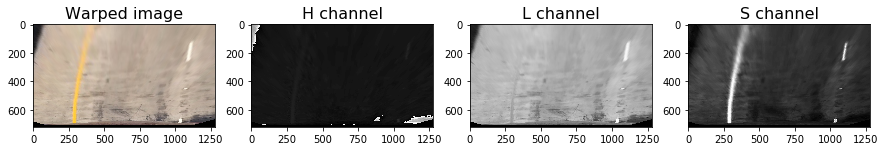

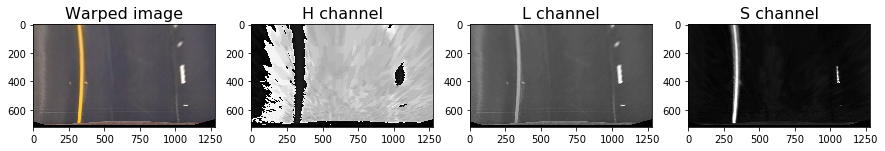

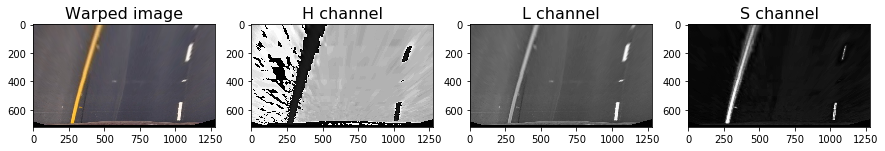

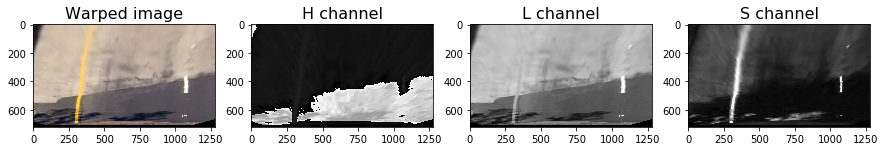

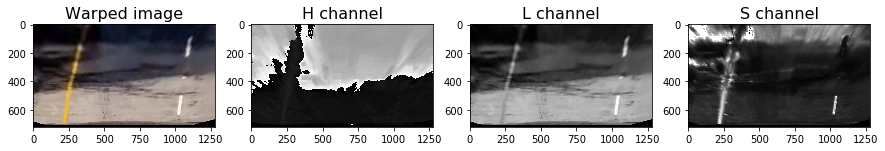

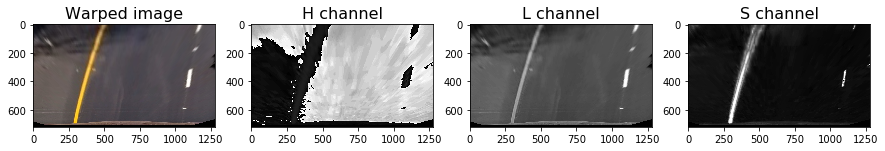

In [11]:
#Pipeline: Get the perspective transformation of the undistorted images
img = undistortImg(imgs[4], mtx, dist)
imgWarped, M, Mi = birdEye(img, src, dst)


for imgWarped in imgsWarped:
    imgColor, imDesc = HLSFilter(imgWarped)
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 4, figsize=(15,5))                                           
    
    axarr[0].imshow(imgWarped)
    axarr[0].set_title('Warped image', fontsize=16)

    axarr[1].imshow(imDesc[0], cmap='gray')
    axarr[1].set_title('H channel', fontsize=16)

    axarr[2].imshow(imDesc[1], cmap='gray')
    axarr[2].set_title('L channel', fontsize=16)

    axarr[3].imshow(imDesc[2], cmap='gray')
    axarr[3].set_title('S channel', fontsize=16) 
    
    

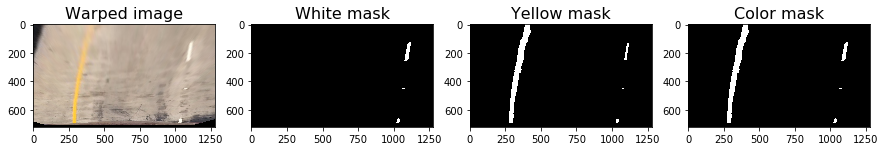

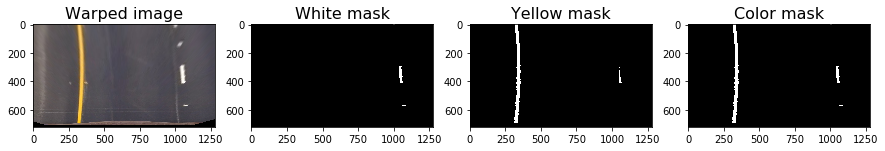

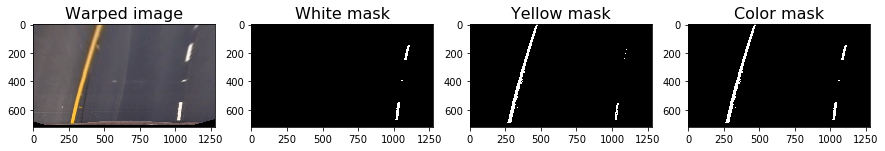

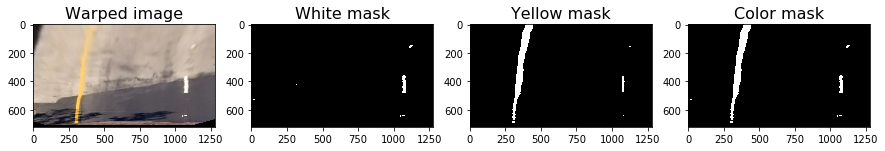

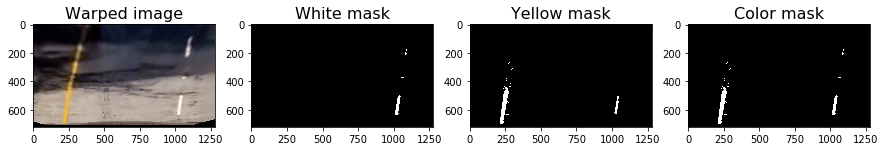

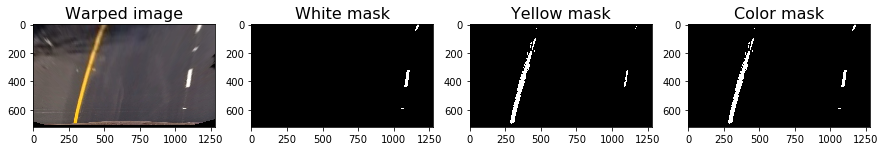

In [12]:
#Color mask 
sensitivity = 45 
WhiteLowMask  = [ 0, 255-sensitivity, 0]
WhiteHighMask = [255, 255, 255]

#yellow mask 
sensitivity = 125 
YellowLowMask  = [ 0, 50, 255-sensitivity]
YellowHighMask = [100, 255, 255]

for img in imgs:
    
    #Pipeline: Get the perspective transformation of the undistorted images and apply color filter
    img = undistortImg(img, mtx, dist)
    imgWarped, M, Mi = birdEye(img, src, dst)
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)
    
    def CombMask(mask_1, mask_2):
        comb = np.zeros_like(mask_1)
        comb[(mask_1 == 1) | (mask_2 == 1)] = 1
        return comb
    
    ImgMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 4, figsize=(15,5))                                           
    
    axarr[0].imshow(imgWarped)
    axarr[0].set_title('Warped image', fontsize=16)
    
    axarr[1].imshow(imgWhiteMask, cmap='gray')
    axarr[1].set_title('White mask', fontsize=16)
    
    axarr[2].imshow(imgYellowMask, cmap='gray')
    axarr[2].set_title('Yellow mask', fontsize=16)
    
    axarr[3].imshow(ImgMask, cmap='gray')
    axarr[3].set_title('Color mask', fontsize=16)

### 3.2 Sobel threslhold

In [13]:
def absSobelThresh(img, orient='x', sobel_kernel=5, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    return binary_output

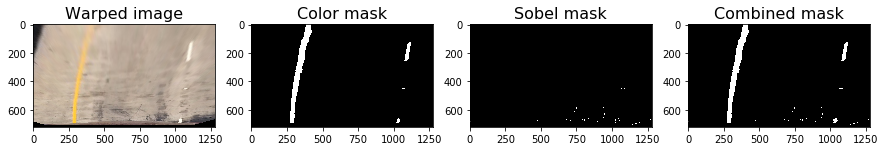

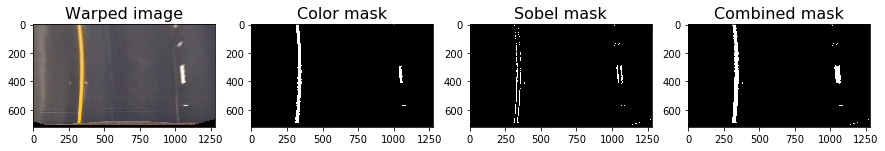

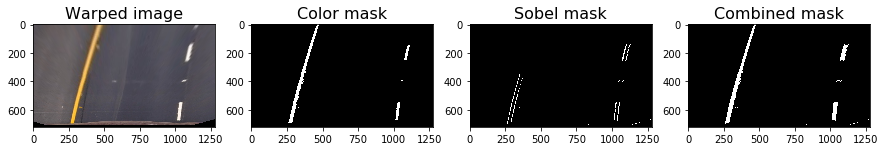

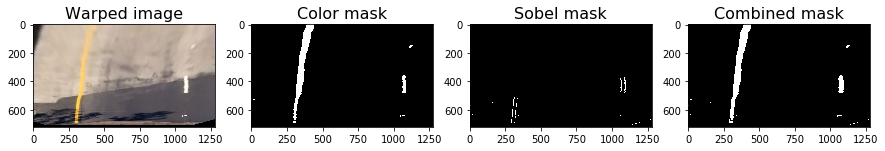

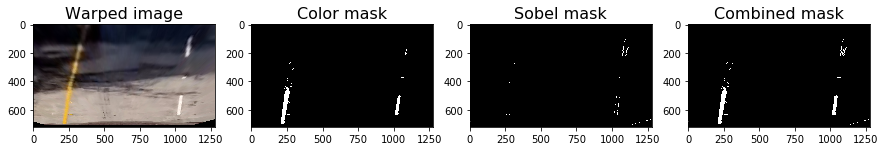

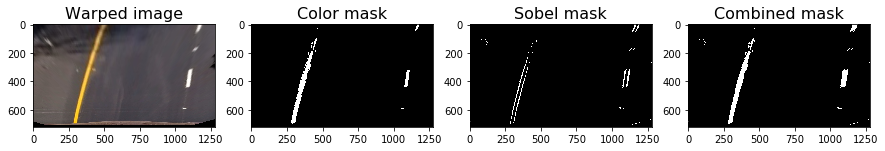

In [14]:
threshVal = (50, 250)

idx = 0
ImgsMask = []

for img in imgs:
    
    #Pipeline: Get the perspective transformation of the undistorted images 
    img = undistortImg(img, mtx, dist)
    imgWarped, M, Mi = birdEye(img, src, dst)
    
    #Color Mask
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)  
    ImgColorMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #Sobel Mask
    ImgSobelMask = absSobelThresh(imgWarped, orient='x', thresh = threshVal)
    #Combined
    ImgMask = CombMask(ImgSobelMask, ImgColorMask)
    ImgsMask.append(ImgMask)
    
    #Save images
    cv2.imwrite("./output_images/ImgMask"+ str(idx) + ".png", 255*ImgMask)
    idx=idx+1
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 4, figsize=(15,5))                                           
    
    axarr[0].imshow(imgWarped)
    axarr[0].set_title('Warped image', fontsize=16)
    
    axarr[1].imshow(ImgColorMask, cmap='gray')
    axarr[1].set_title('Color mask', fontsize=16)
    
    axarr[2].imshow(ImgSobelMask, cmap='gray')
    axarr[2].set_title('Sobel mask', fontsize=16)
                          
    axarr[3].imshow(ImgMask, cmap='gray')
    axarr[3].set_title('Combined mask', fontsize=16)

## 4 Finding the lines and calculate the curvature

### 4.1 Measuring the curvature

In [15]:
def curvMeasuring(y, x):
    
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    #ym_per_pix = 1
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #xm_per_pix = 1
    
    if((len(x) > 0) & (len(y) > 0)):
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
        # Calculate the new radii of curvature
        curveRad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
       
        return curveRad
    else:
        return 0

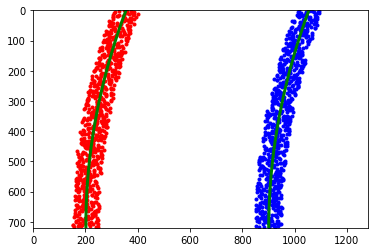

In [16]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [17]:
left_curverad = curvMeasuring(ploty, leftx)
right_curverad = curvMeasuring(ploty, rightx)

print("Left curve radio:", left_curverad, 'm', "\nRight curve radio: ", right_curverad, 'm')

Left curve radio: 538.695338976 m 
Right curve radio:  558.900752266 m


### 4.2 Finding the lines on the first frame

#### 4.2.1 Histogram and base points

In [18]:
PLOT = 1

def basePoints(img):
    
    midpoint = int(img.shape[0]/2)
    #Create a histogram of the lower half of the image
    histogram = np.sum(img[500:,:], axis=0)
    
    #Find the base points by finding the max value on the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    return leftx_base, rightx_base, histogram

Mean Inte Lane distance:  752.5


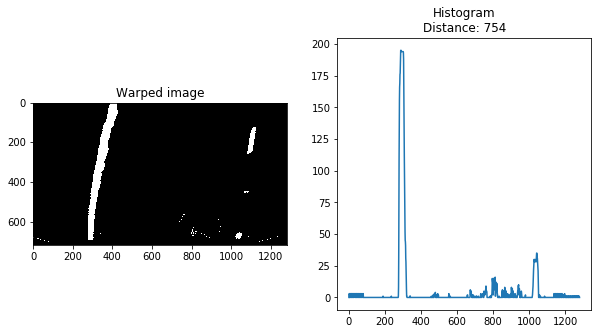

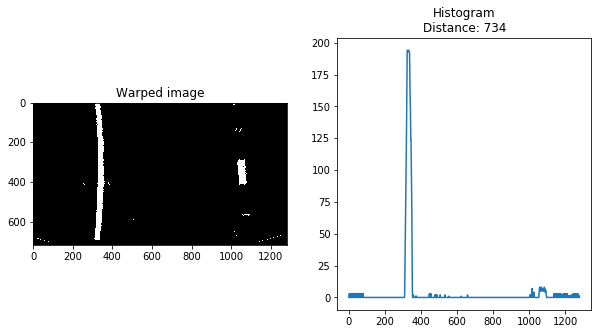

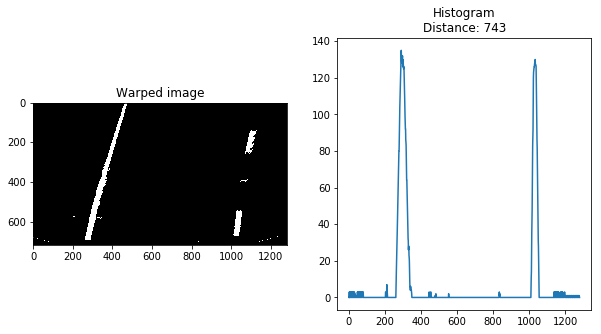

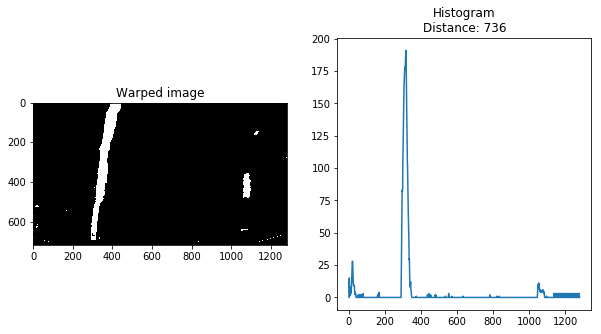

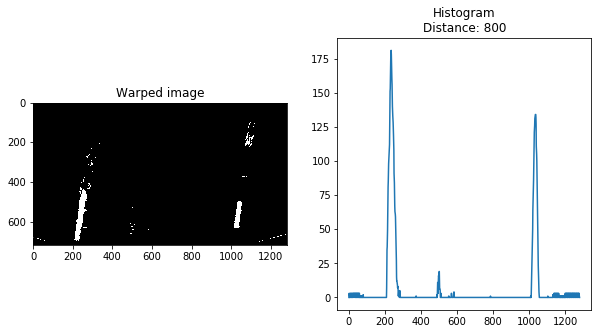

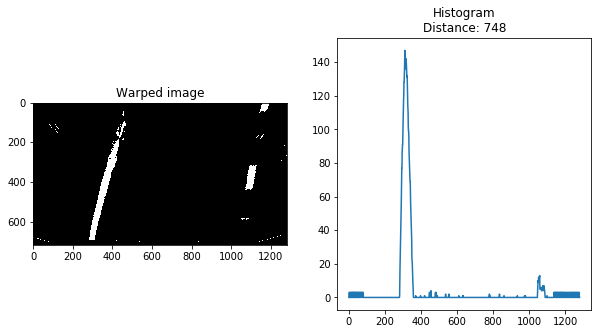

In [19]:
interLaneDistance = 0

for imgMask in ImgsMask:
    
    img = np.array(imgMask)
    leftx_base, rightx_base,  histogram = basePoints(img)
    
    interLaneDistance += (rightx_base - leftx_base)

    f, axarr = plt.subplots(1, 2, figsize=(10,5))
        
    axarr[0].imshow(img, cmap='gray')
    axarr[0].set_title('Warped image', fontsize=12)
    
    axarr[1].plot(histogram)
    title = "".join(['Histogram\n', 'Distance: ', str(rightx_base - leftx_base)])
    axarr[1].set_title(title, fontsize=12)

interLaneDistance = interLaneDistance/len(ImgsMask) 

print("Mean Inte Lane distance: ", interLaneDistance)

#### 4.2.2 Fit the polynomial

In [20]:
def fitLineInitPolynomial(img, margin):
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Search for base points
    leftx_base, rightx_base,  histogram = basePoints(img)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
      
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4)
       
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #Caculare the curvature radius
    left_curveRad = curvMeasuring(lefty, leftx)
    right_curveRad = curvMeasuring(righty, rightx)
    
    #initializes the polynomial array
    left_fit = np.array([0,0,0])
    right_fit = np.array([0,0,0])
    
    #Check for the size of the array to avoid errors
    if((leftx.size>0) & (lefty.size>0)):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)   
    
    #Check for the size of the array to avoid errors
    if((rightx.size>0) & (righty.size>0)):
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_curveRad, right_curveRad,  out_img, (leftx, lefty, rightx, righty)
   

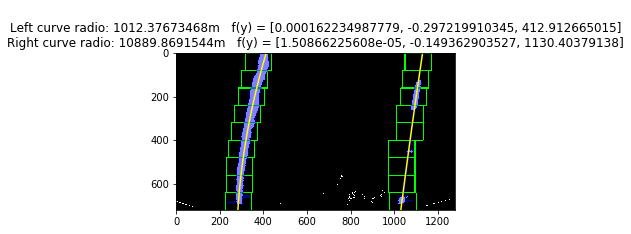

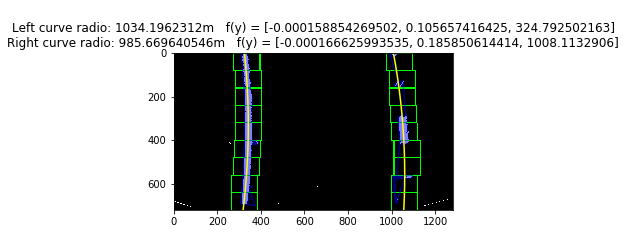

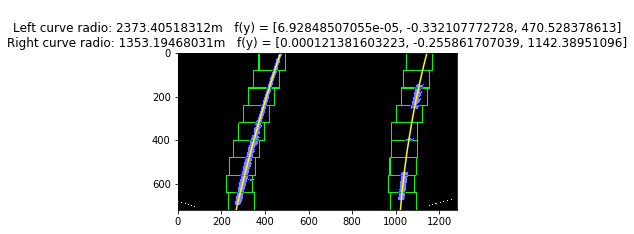

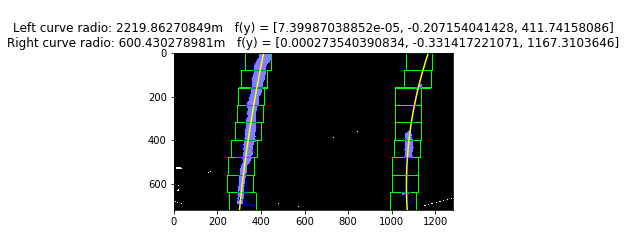

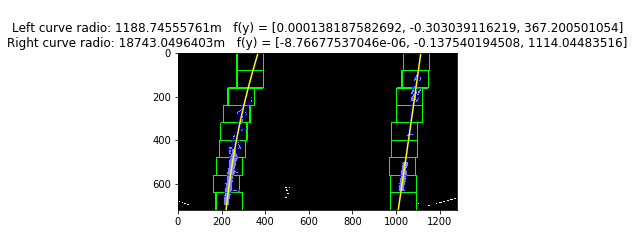

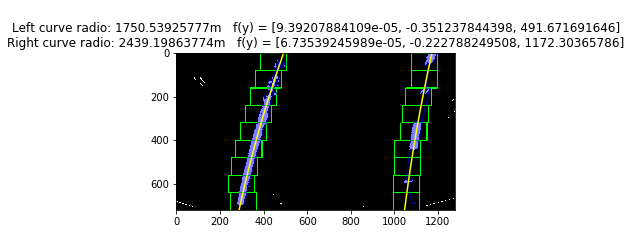

In [21]:
margin = 60

for img in ImgsMask[0:6]:
    left_fit_init, right_fit_init, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(img, margin)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )

    left_fitx = left_fit_init[0]*ploty**2 + left_fit_init[1]*ploty + left_fit_init[2]
    right_fitx = right_fit_init[0]*ploty**2 + right_fit_init[1]*ploty + right_fit_init[2]
    #right_fitx = right_fit_init[0]*ploty**2 + right_fit_init[1]*ploty + right_fit_init[2]
    
    f, axarr = plt.subplots(1, 1, figsize=(5,5))
    axarr.imshow(out_img)
    axarr.plot(nonzero[0], nonzero[1], color='blue', alpha=0.5)
    axarr.plot(nonzero[2], nonzero[3], color='blue', alpha=0.5)
    axarr.plot(left_fitx, ploty, color='yellow')
    axarr.plot(right_fitx, ploty, color='yellow')
    text = "".join(["\nLeft curve radio: ", str(left_curveRad), 'm', "   f(y) = [", str(left_fit_init[0]), ", ", str(left_fit_init[1]), ", ", str(left_fit_init[2]), "]" ])
    text = "".join([text, "\nRight curve radio: ", str(right_curveRad), 'm',"   f(y) = [", str(right_fit_init[0]), ", ", str(right_fit_init[1]), ", ", str(right_fit_init[2]), "]" ])
    axarr.set_title(text, fontsize=12)

    #print("Left curve radio:", left_curveRad, 'm', "\nRight curve radio: ", right_curveRad, 'm\n')

### 4.3 Finding the lines after the first frame

In [51]:
def fitLinePolynomial(img, left_fit, right_fit, margin = 100):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
      
    #Caculare the curvature radius
    left_curveRad = curvMeasuring(lefty, leftx)
    right_curveRad = curvMeasuring(righty, rightx)
    
    #initializes the polynomial array
    left_fit = np.array([0,0,0])
    right_fit = np.array([0,0,0])
    
    #Check for the size of the array to avoid errors
    if((leftx.size>0) & (lefty.size>0)):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)   
    
    #Check for the size of the array to avoid errors
    if((rightx.size>0) & (righty.size>0)):
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_curveRad, right_curveRad, (leftx, lefty, rightx, righty)
   

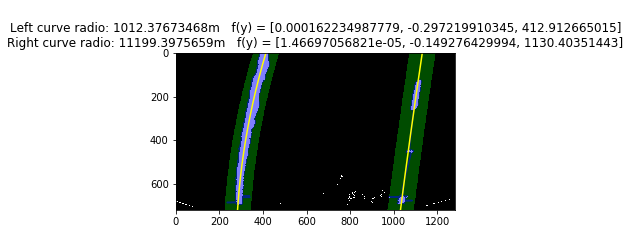

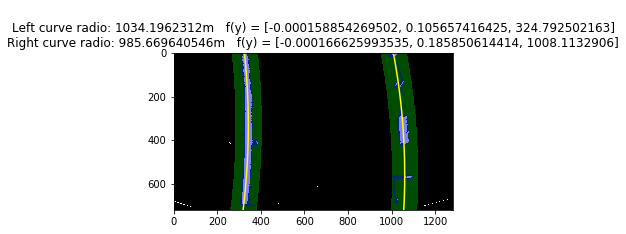

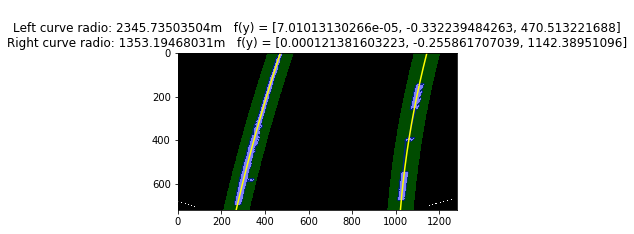

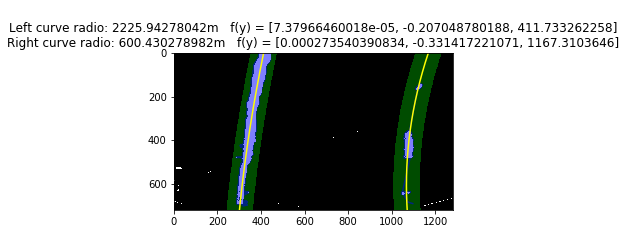

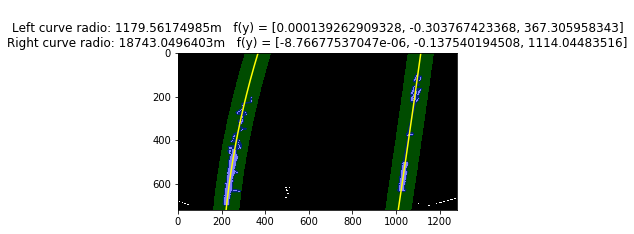

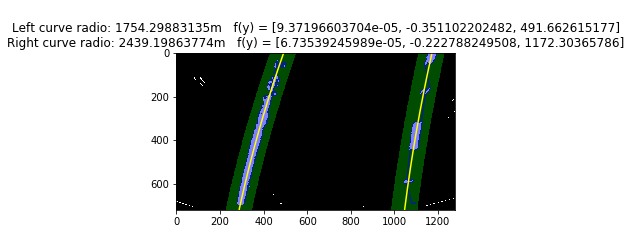

In [52]:
for img in ImgsMask[0:6]:
    margin = 60
    left_fit_init, right_fit_init, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(img, margin)
    left_fit, right_fit, left_curveRad, right_curveRad, nonzero = fitLinePolynomial(img, left_fit_init, right_fit_init, margin)

    #print("Left curve radio:", left_curveRad, 'm', "\nRight curve radio: ", right_curveRad, 'm')

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                                                                    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
                                                                    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    f, axarr = plt.subplots(1, 1, figsize=(5,5))
    axarr.imshow(result)
    axarr.plot(nonzero[0], nonzero[1], color='blue', alpha=0.5)
    axarr.plot(nonzero[2], nonzero[3], color='blue', alpha=0.5)
    axarr.plot(left_fitx, ploty, color='yellow')
    axarr.plot(right_fitx, ploty, color='yellow') 
    text = "".join(["\nLeft curve radio: ", str(left_curveRad), 'm', "   f(y) = [", str(left_fit[0]), ", ", str(left_fit[1]), ", ", str(left_fit[2]), "]" ])
    text = "".join([text, "\nRight curve radio: ", str(right_curveRad), 'm',"   f(y) = [", str(right_fit[0]), ", ", str(right_fit[1]), ", ", str(right_fit[2]), "]" ])
    axarr.set_title(text, fontsize=12)
                                                                    

## 5 Drawing

In [24]:
def drawing(img, warped, Minv, left_fit, right_fit):
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)


    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array(pts, np.int32)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, pts, (0,255, 0))
    #plt.imshow(warp_zero)  

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result
      

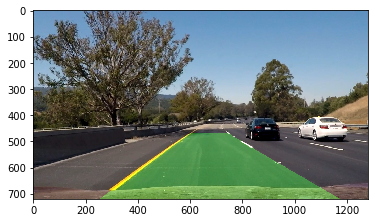

In [25]:
img = drawing(imgs[5], imgsWarped[5], Mi, left_fit, right_fit)

plt.imshow(img)  

## 6. Pipeline

In [26]:
def pipeline(img):
    
    # Unditort image
    imgUndist = undistortImg(img, mtx, dist)
    
    #Apply perpective transformation
    imgWarped, M, Mi = birdEye(imgUndist, src, dst)
    
    #Apply color mask
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)  
    ImgColorMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #Apply Sobbel mask
    ImgSobelMask = absSobelThresh(imgWarped, orient='x', thresh = threshVal)
    ImgMask = CombMask(ImgSobelMask, ImgColorMask)
    
    #Fit polynomial
    left_fit, right_fit, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(ImgMask, margin)
    mean_curveRad = (left_curveRad + right_curveRad)/2
    
    #Draw the area
    result = drawing(imgUndist, imgWarped, Mi, left_fit, right_fit)
    
    #print curvature in image
    text = "".join(["Left curve radio:", str(left_curveRad), 'm'])
    cv2.putText(result,text,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = "".join([ "Right curve radio: ", str(right_curveRad), 'm'])
    cv2.putText(result,text,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    return result
    

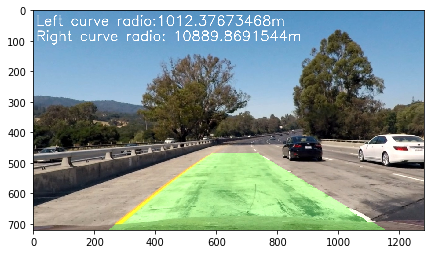

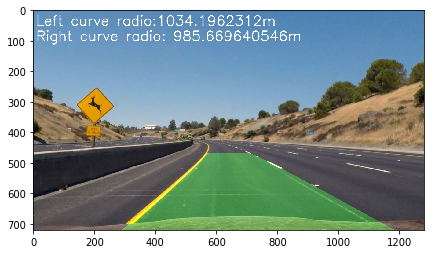

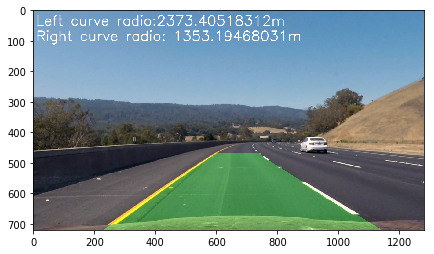

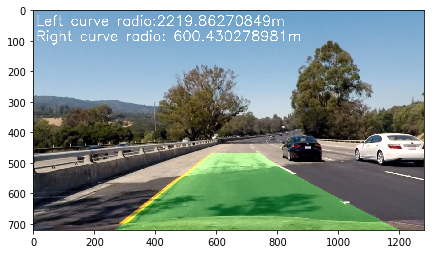

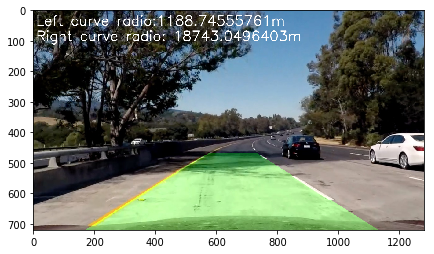

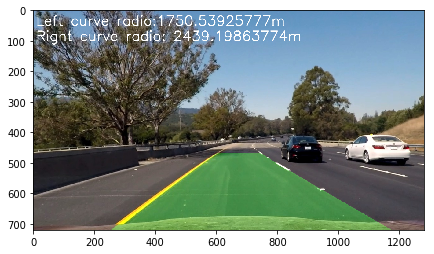

In [27]:
results = []

for img in imgs:
    
    #Pipeline: Get the perspective transformation of the undistorted images 
    result = pipeline(img)
    
    #display transformation images and color filter
    f, axarr = plt.subplots(1, 1, figsize=(7,5))                                           
    
    axarr.imshow(result)

## 7. Video processing

In [28]:
from moviepy.editor import VideoFileClip

clip_output = 'test_videos_output/AdvanceLanDetection.mp4'

clip = VideoFileClip("project_video.mp4")
#clip = clip.fl_image(pipeline).subclip(0,10)
clip = clip.fl_image(pipeline)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/AdvanceLanDetection.mp4
[MoviePy] Writing video test_videos_output/AdvanceLanDetection.mp4


100%|█████████▉| 1260/1261 [04:08<00:00,  5.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/AdvanceLanDetection.mp4 

CPU times: user 4min 51s, sys: 3.05 s, total: 4min 54s
Wall time: 4min 10s


## 8. Pipeline plus

### 8.1 Line class definition

In [29]:
class Line():       
    def __init__(self):

        # was the line detected in the last iteration?
        self.detected = False    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0])  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0,0,0]) 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #Curvatures of the last n iterations
        self.cuvature_log = []
    
    def setCurrentSts(self, currentFit, curvature):
               
        #Calculate best fit
        if(self.detected == True):
            self.current_fit = currentFit
            self.best_fit = (self.best_fit + currentFit)/2
            self.radius_of_curvature = (self.radius_of_curvature + curvature)/2
        else:
            self.diffs = currentFit - self.current_fit 
            self.current_fit = currentFit
            self.best_fit = currentFit
            self.radius_of_curvature = curvature
        
        #Log the curvatures
        self.cuvature_log.append(self.radius_of_curvature)
        
        #Set detected as True
        self.detected = True
    
    def getDetected(self):
        return self.detected
    
    def getBestFit(self):
        return self.best_fit
    
    def getCurvature(self):
        return self.radius_of_curvature
    
    def getCurvatureLog(self):
        return self.cuvature_log
        

### 8.2 Sanity check

In [30]:
def CheckParallel(img, left_fit, right_fit):
        
    #ImageDimenstion
    imgDim = np.array(img).shape
          
    pts = np.array(range(0, imgDim[1], 100))
        
    leftPtsX = np.array(pts)
    rightPtsX = np.array(pts)
        
    for pt in range(len(pts)):
        leftPtsX[pt] = left_fit[0]*pts[pt]**2 + left_fit[1]*pts[pt] + left_fit[2]      
        rightPtsX[pt] = right_fit[0]*pts[pt]**2 + right_fit[1]*pts[pt] + right_fit[2]
        
    meanDistance = np.mean(rightPtsX - leftPtsX)
        
    if((interLaneDistance*0.9 < meanDistance) & (meanDistance < interLaneDistance*1.1)):
        return True
    else:
        return False

In [31]:
def SanityCheck(img, left_fit, right_fit, left_curveRad, right_curveRad):
    checkParallelResult = CheckParallel(img, left_fit, right_fit)  
    return checkParallelResult
            

### 8.3 Pipeline plus definition

In [42]:
L_Line = Line()
R_Line = Line()

def pipelinePlus(img):
       
    # Unditort image
    imgUndist = undistortImg(img, mtx, dist)
    
    #Apply perpective transformation
    imgWarped, M, Mi = birdEye(imgUndist, src, dst)
    
    #Apply color mask
    imgWhiteMask, imgWhiteDesc = HLSFilter(imgWarped, WhiteLowMask, WhiteHighMask)
    imgYellowMask, imgYellowDesc = HLSFilter(imgWarped, YellowLowMask, YellowHighMask)  
    ImgColorMask = CombMask(imgWhiteMask, imgYellowMask)
    
    #Apply Sobbel mask
    ImgSobelMask = absSobelThresh(imgWarped, orient='x', thresh = threshVal)
    ImgMask = CombMask(ImgSobelMask, ImgColorMask)
    
    #Fit polynomial
    if(L_Line.getDetected() == False | R_Line.getDetected() == False):
        
        left_fit, right_fit, left_curveRad, right_curveRad, out_img, nonzero = fitLineInitPolynomial(ImgMask, margin)
        sanity = True
            
    else:
        left_fit = L_Line.getBestFit()
        right_fit = R_Line.getBestFit()
        
        left_fit, right_fit, left_curveRad, right_curveRad, nonzero = fitLinePolynomial(ImgMask, left_fit, right_fit, margin)
        sanity = SanityCheck(img, left_fit, right_fit, left_curveRad, right_curveRad)
        
    if(sanity):
        L_Line.setCurrentSts(left_fit, left_curveRad )
        R_Line.setCurrentSts(right_fit, right_curveRad )
    
    
    left_fit = L_Line.getBestFit()
    right_fit = R_Line.getBestFit()
    
    #Draw the area
    result = drawing(imgUndist, imgWarped, Mi, left_fit, right_fit)
    
    #print curvature in image
    left_curveRad = L_Line.getCurvature()
    right_curveRad = R_Line.getCurvature()
    text = "".join(["Left curve radio:", str(left_curveRad), 'm'])
    cv2.putText(result,text,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = "".join([ "Right curve radio: ", str(right_curveRad), 'm'])
    cv2.putText(result,text,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    return result

### 8.4 Video processing with pipeline plus

In [34]:
L_Line = Line()
R_Line = Line()

clip_output = 'test_videos_output/AdvanceLanDetectionPlus.mp4'

clip = VideoFileClip("project_video.mp4")
#clip = clip.fl_image(pipelinePlus).subclip(0,5)
clip = clip.fl_image(pipelinePlus)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/AdvanceLanDetectionPlus.mp4
[MoviePy] Writing video test_videos_output/AdvanceLanDetectionPlus.mp4


100%|█████████▉| 1260/1261 [03:56<00:00,  5.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/AdvanceLanDetectionPlus.mp4 

CPU times: user 4min 44s, sys: 2.75 s, total: 4min 47s
Wall time: 3min 58s


### 8.5 Curvature log

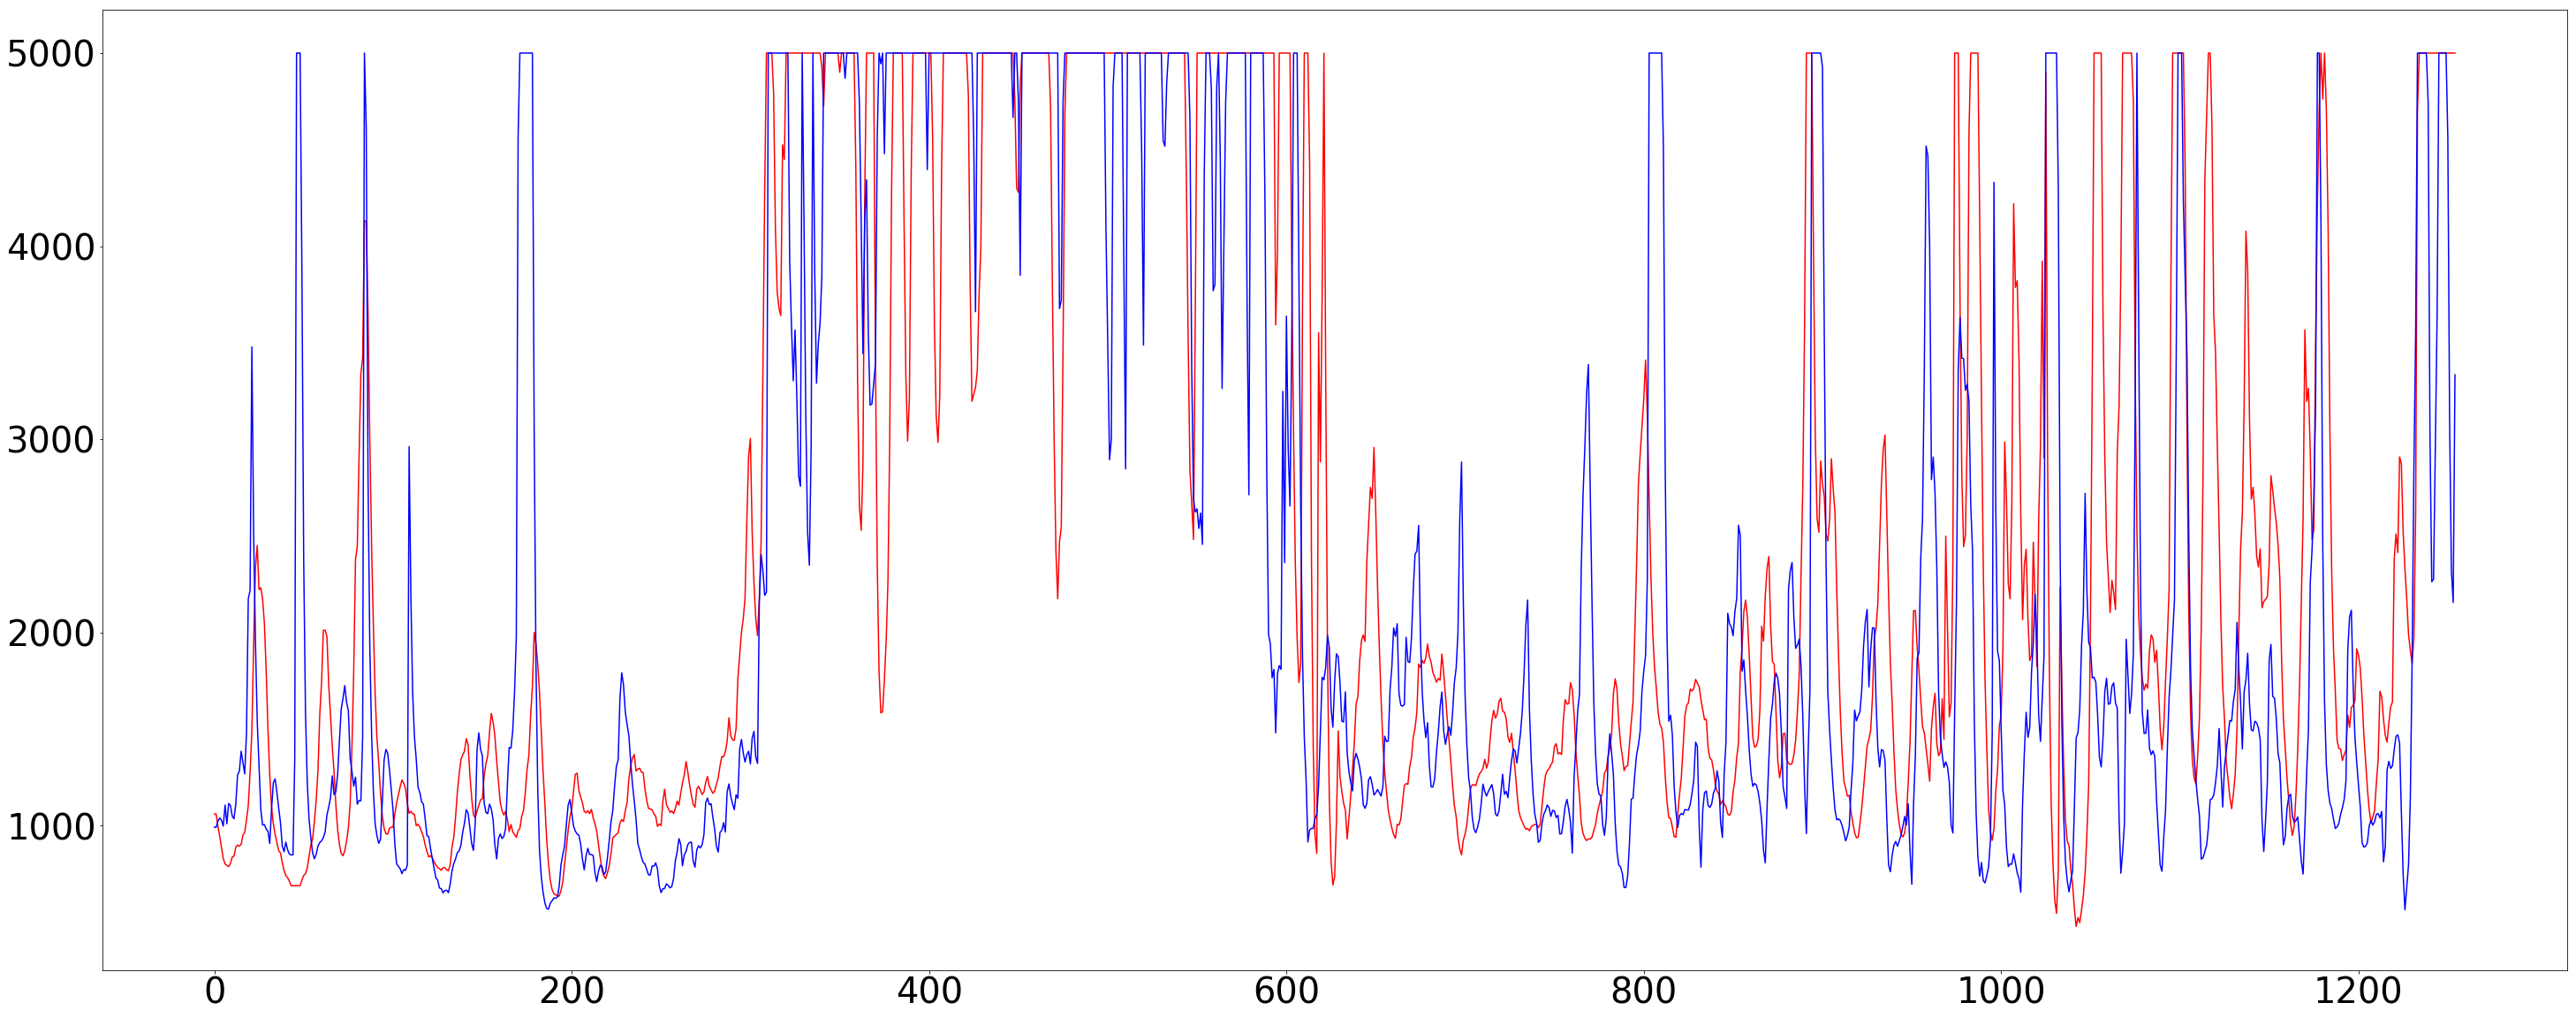

In [35]:
frames = range(0,len(L_Line.getCurvatureLog()))

f, axarr = plt.subplots(1, 1, figsize=(50,20))

leftCurvLog = np.array(L_Line.getCurvatureLog(), dtype = np.float32)
leftCurvLog[leftCurvLog > 5000] = 5000
axarr.plot(frames, leftCurvLog, color='red')
axarr.tick_params(labelsize=40)

rightCurvLog = np.array(R_Line.getCurvatureLog(), dtype = np.float32)
rightCurvLog[rightCurvLog > 5000] = 5000
axarr.plot(frames, rightCurvLog, color='blue')

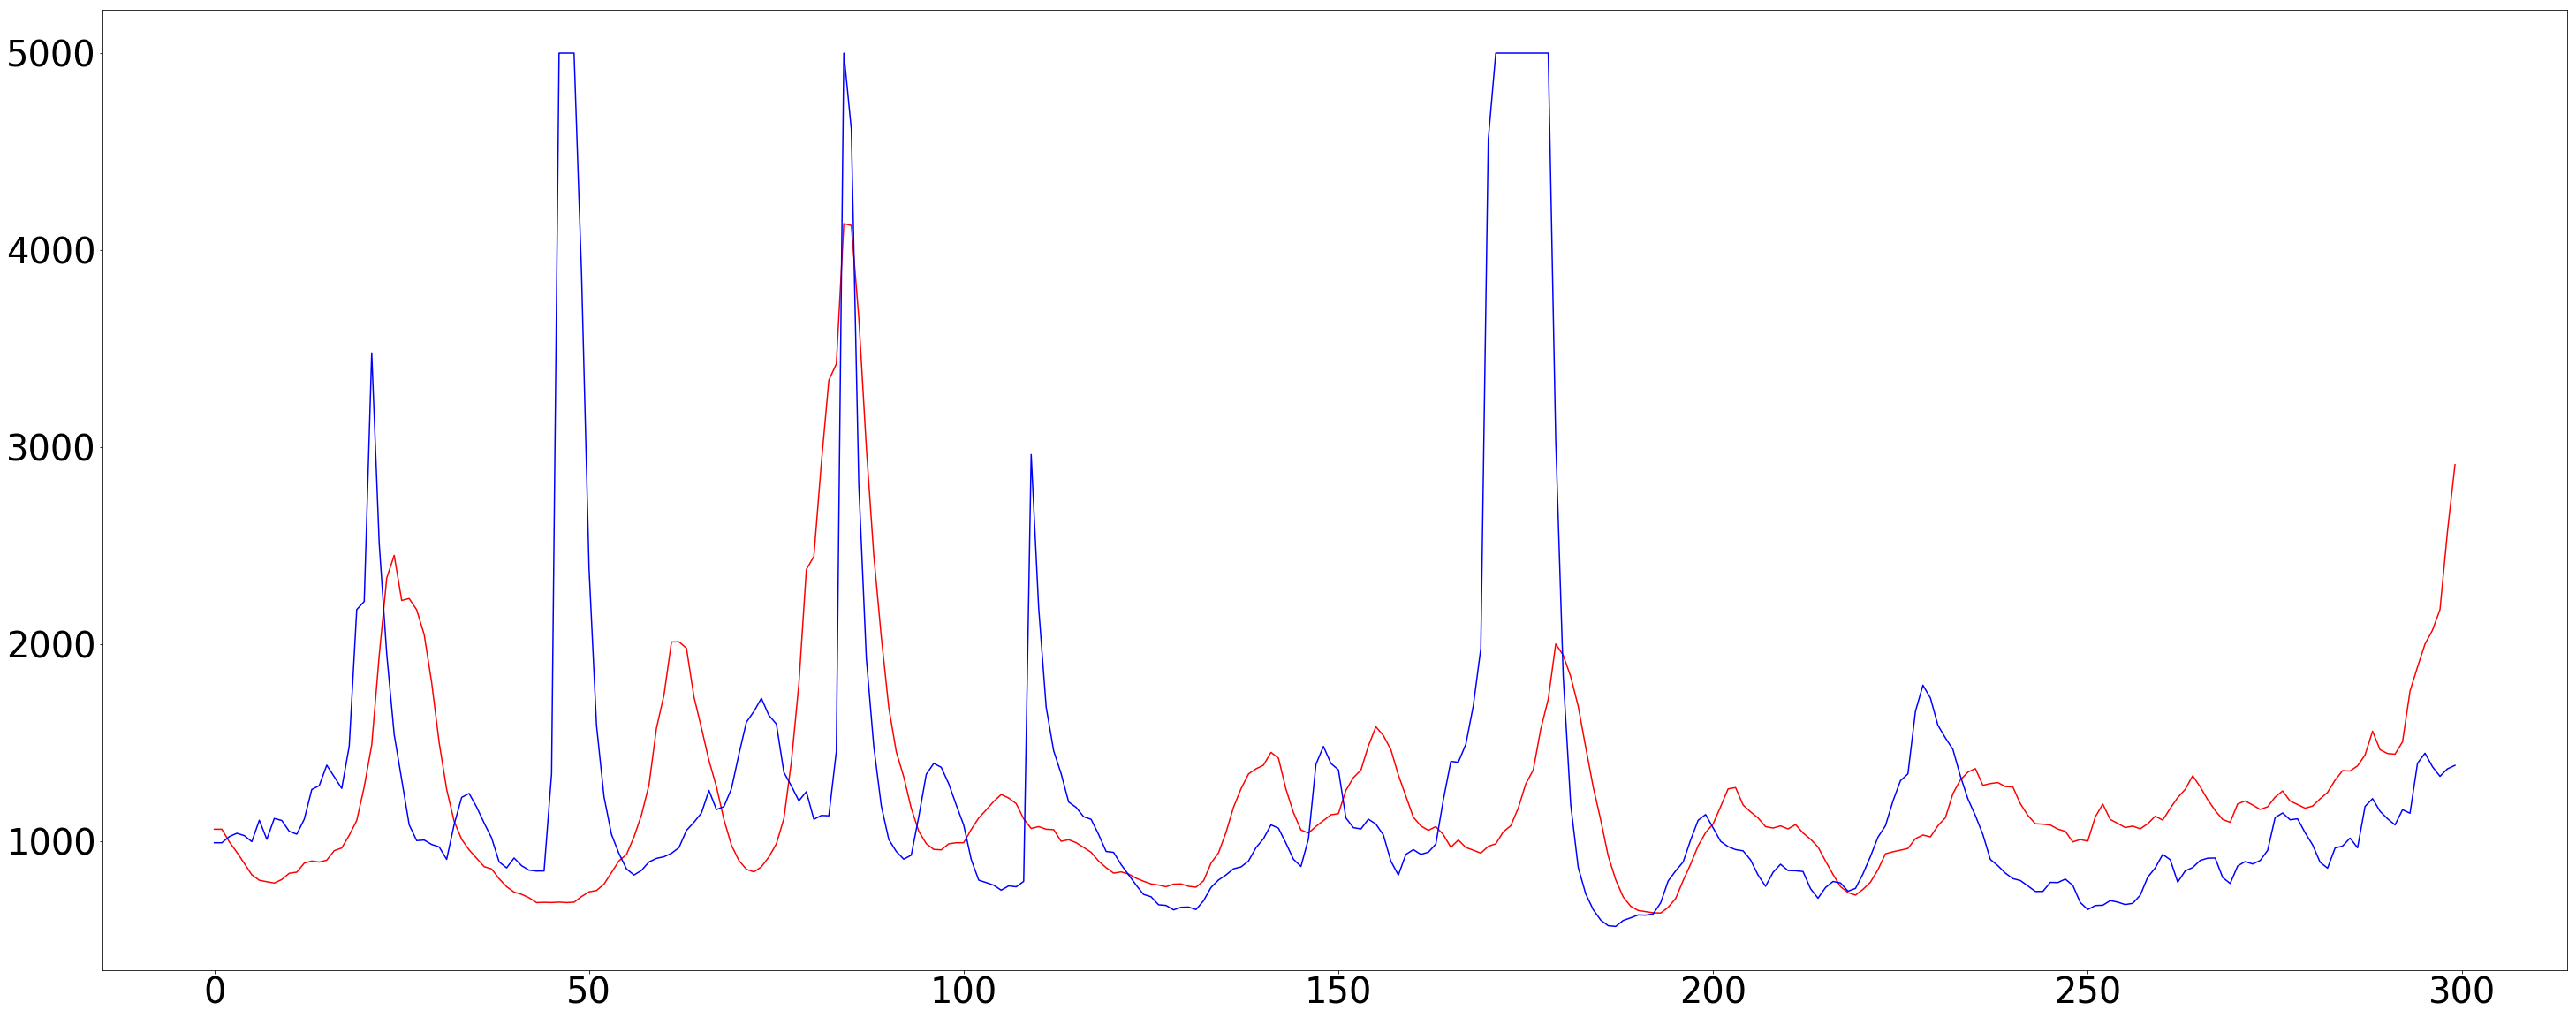

In [36]:
frames = range(0,300)

f, axarr = plt.subplots(1, 1, figsize=(50,20))

leftCurvLog = np.array(L_Line.getCurvatureLog(), dtype = np.float32)
leftCurvLog[leftCurvLog > 5000] = 5000
axarr.plot(frames, leftCurvLog[0:300], color='red')
axarr.tick_params(labelsize=40)

rightCurvLog = np.array(R_Line.getCurvatureLog(), dtype = np.float32)
rightCurvLog[rightCurvLog > 5000] = 5000
axarr.plot(frames, rightCurvLog[0:300], color='blue')

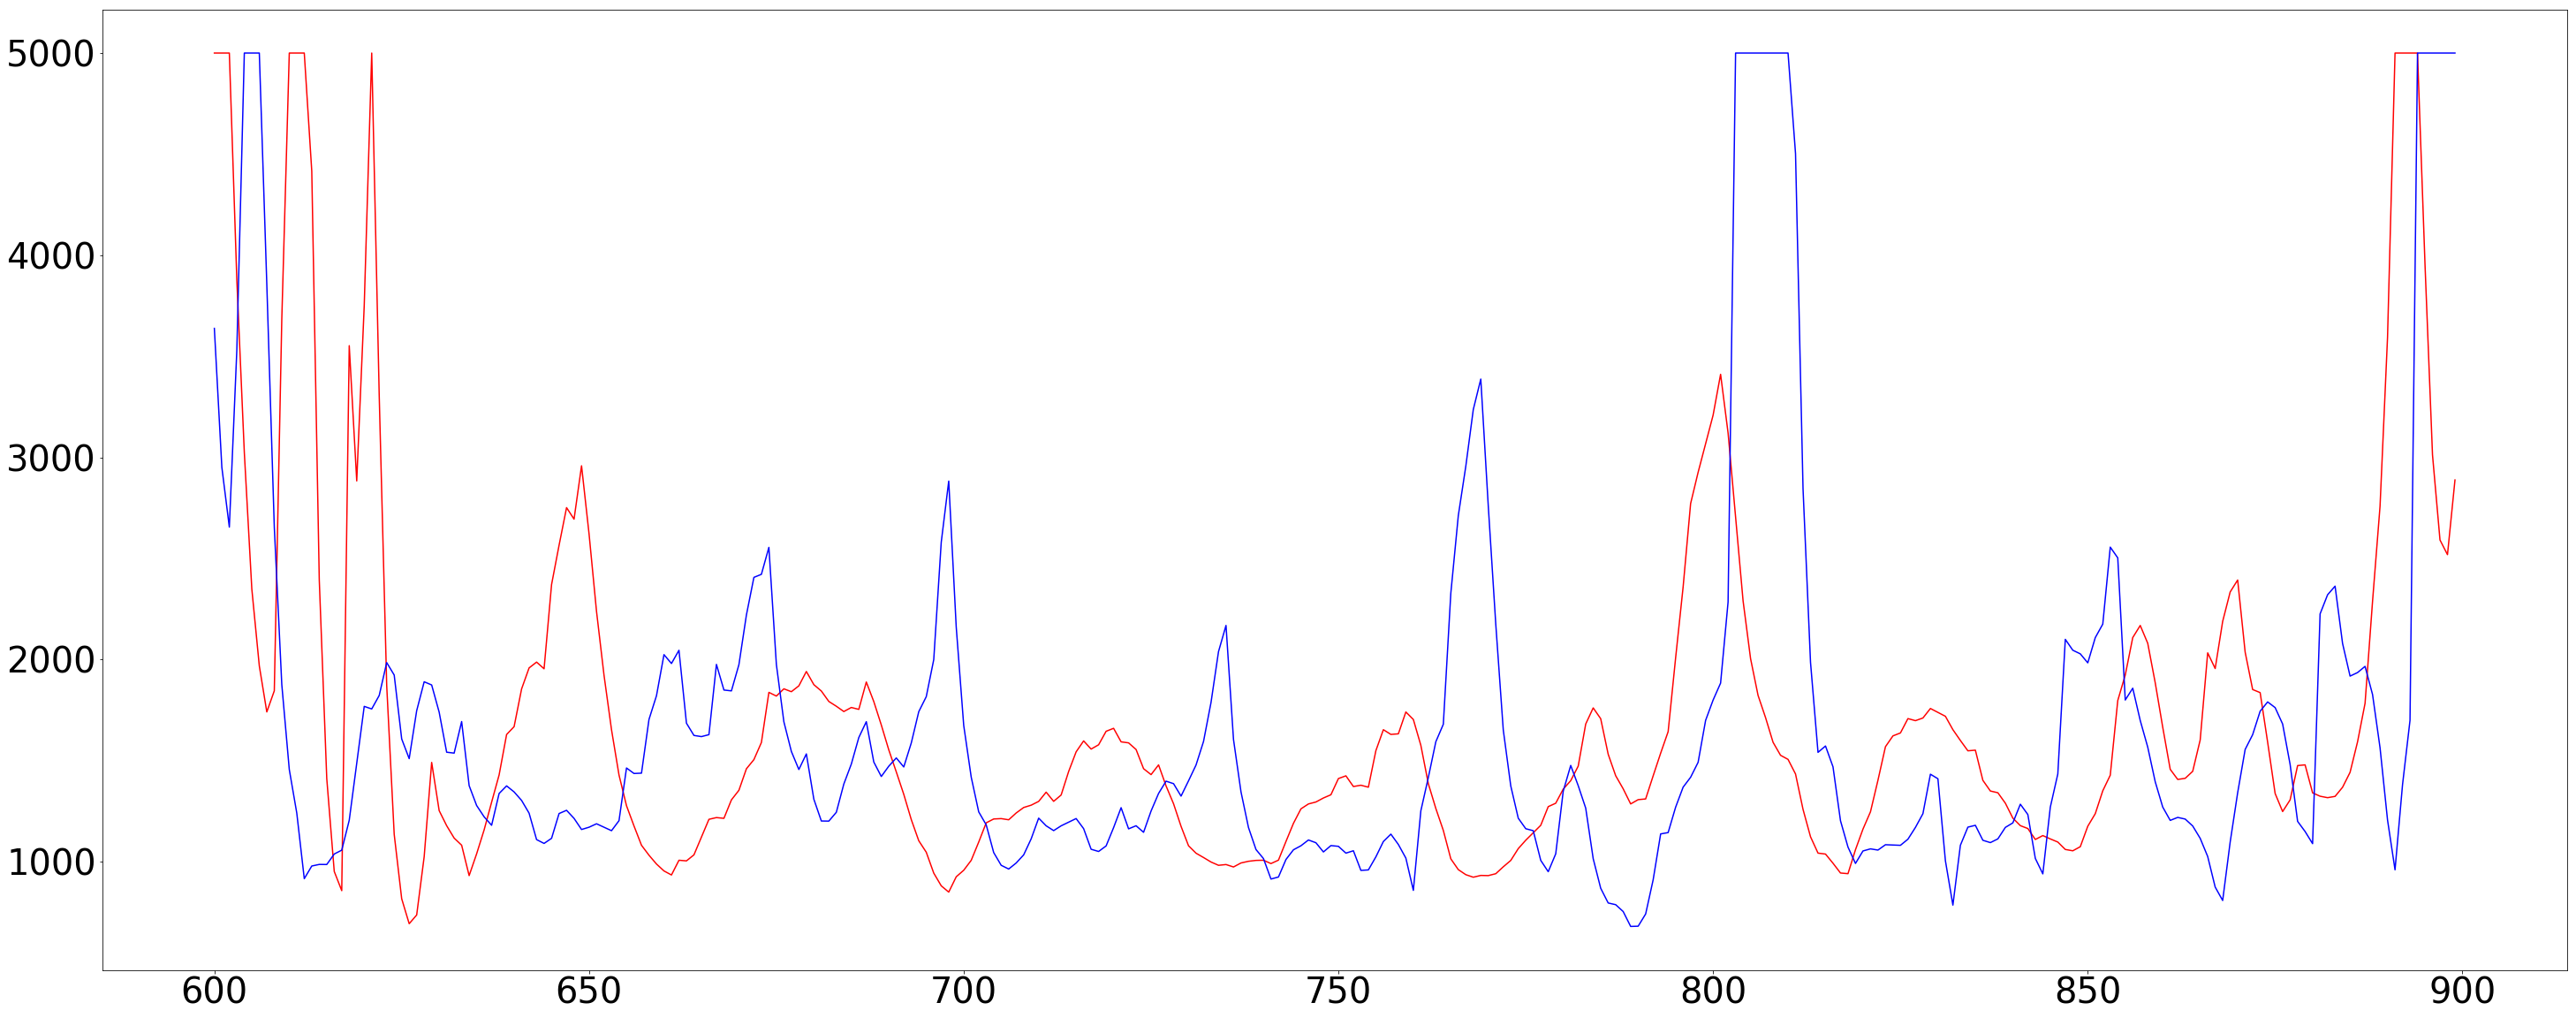

In [37]:
frames = range(600,900)

f, axarr = plt.subplots(1, 1, figsize=(50,20))

leftCurvLog = np.array(L_Line.getCurvatureLog(), dtype = np.float32)
leftCurvLog[leftCurvLog > 5000] = 5000
axarr.plot(frames, leftCurvLog[600:900], color='red')
axarr.tick_params(labelsize=40)

rightCurvLog = np.array(R_Line.getCurvatureLog(), dtype = np.float32)
rightCurvLog[rightCurvLog > 5000] = 5000
axarr.plot(frames, rightCurvLog[600:900], color='blue')

## 9. Challenge

### 9.1 Video processing 

In [54]:
L_Line = Line()
R_Line = Line()

clip_output = 'test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4'

clip = VideoFileClip("challenge_video.mp4")
clip = clip.fl_image(pipelinePlus).subclip(0,10)
#clip = clip.fl_image(pipelinePlus)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4
[MoviePy] Writing video test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4



 52%|█████▏    | 155/300 [00:27<00:26,  5.43it/s]


100%|██████████| 300/300 [00:55<00:00,  5.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/ChallengeAdvanceLanDetectionPlus.mp4 

CPU times: user 1min 4s, sys: 828 ms, total: 1min 5s
Wall time: 56.8 s
